# Mobile Price Range predictor


1. Mobile price prediction using set of features.

2. It is a classification problem.





**Algorithms going to be used**
-  Softmax classifier 
-  Deep Neural Networks

In [112]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
train_data=pd.read_csv('/content/mobile-train.csv',encoding='latin')
train_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


# Data preprocessing

Removing null Rows

In [108]:
train_data=train_data.dropna()

In [109]:
columns= train_data.columns
sc= sklearn.preprocessing.StandardScaler()
sc.fit(train_data.iloc[:,:-1])
train_data_scaled = sc.transform(train_data.iloc[:,:-1])
train_data_scaled = pd.DataFrame(np.hstack([train_data_scaled,np.array(train_data.iloc[:,-1],dtype='int').reshape(train_data.shape[0],1)]),columns=columns)

In [110]:
train_data_scaled

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-0.902597,-0.990050,0.830779,-1.019184,-0.762495,-1.043966,-1.380644,0.340740,1.349249,-1.101971,-1.305750,-1.408949,-1.146784,0.391703,-0.784983,0.283103,1.462493,-1.786861,-1.006018,0.986097,1.0
1,-0.495139,1.010051,-1.253064,0.981177,-0.992890,0.957886,1.155024,0.687548,-0.120059,-0.664768,-0.645989,0.585778,1.704465,0.467317,1.114266,-0.635317,-0.734267,0.559641,0.994018,-1.014099,2.0
2,-1.537686,1.010051,-1.253064,0.981177,-0.532099,0.957886,0.493546,1.381165,0.134244,0.209639,-0.645989,1.392684,1.074968,0.441498,-0.310171,-0.864922,-0.368140,0.559641,0.994018,-1.014099,2.0
3,-1.419319,1.010051,1.198517,-1.019184,-0.992890,-1.043966,-1.215274,1.034357,-0.261339,0.646842,-0.151168,1.286750,1.236971,0.594569,0.876859,0.512708,-0.002014,0.559641,-1.006018,-1.014099,2.0
4,1.325906,1.010051,-0.395011,-1.019184,2.002254,0.957886,0.658915,0.340740,0.021220,-1.101971,0.673534,1.268718,-0.091452,-0.657666,-1.022389,-0.864922,0.730240,0.559641,0.994018,-1.014099,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.011860,1.010051,-1.253064,0.981177,-0.992890,0.957886,-1.656260,1.034357,-0.967737,0.646842,0.673534,1.300273,1.477661,-1.342799,0.164641,-0.405712,1.462493,0.559641,0.994018,-1.014099,0.0
1996,1.653694,1.010051,1.321096,0.981177,-0.992890,-1.043966,0.383299,-1.046495,1.320993,-0.227564,-1.140810,0.608317,1.651235,-0.085031,-0.310171,0.971917,0.913303,0.559641,0.994018,0.986097,2.0
1997,1.530773,-0.990050,-0.762748,0.981177,-0.762495,0.957886,0.217930,0.687548,-0.911225,1.521249,-1.140810,0.502383,0.880565,0.860139,-0.784983,-1.094526,-1.100394,0.559641,0.994018,-1.014099,3.0
1998,0.622527,-0.990050,-0.762748,-1.019184,-0.071307,0.957886,0.769162,-1.393304,0.134244,0.209639,-0.810929,-0.696707,-1.345816,-1.157454,1.351672,0.971917,1.462493,0.559641,0.994018,0.986097,0.0


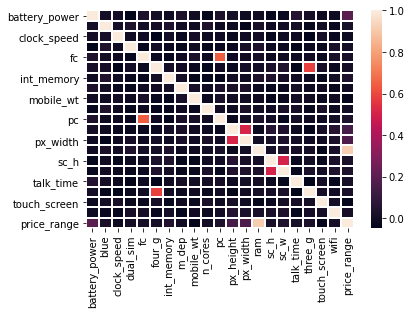

In [111]:
sns.heatmap(train_data_scaled.corr(),linewidths=1)

number of features     -     21  (so we have to do feature engineering to reduce the dimensionaly of data set )

**Taking top 7 best correlated features for training the model**

In [405]:
def send_data(features,train_data,train_data_scaled):
  correlation_columns = abs(train_data.corr()).iloc[:-1,-1].sort_values().index[-1*features:]
  correlation_values = np.array(abs(train_data.corr()).iloc[:-1,-1].sort_values())[-features*i:]
  x_data= train_data_scaled[correlation_columns]
  y_data = train_data['price_range']
  x_data=np.array(x_data)
  x_train,x_val, y_train,y_val = sklearn.model_selection.train_test_split(x_data,y_data,test_size=0.2)
  return x_train,x_val,y_train,y_val

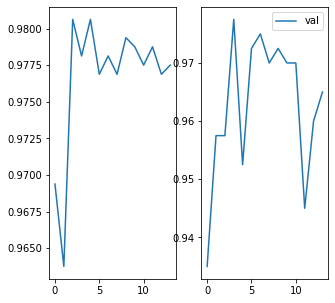

In [411]:
train_accuracy=[]
val_accuracy=[]
for i in range(7,21):
  x_train,x_val, y_train,y_val = send_data(i,train_data,train_data_scaled)
  lor = sklearn.linear_model.LogisticRegression(penalty='l2')
  lor.fit(x_train,y_train)
  pred = lor.predict(x_train)
  train_accuracy.append(lor.score(x_train,y_train))
  val_accuracy.append(lor.score(x_val,y_val))
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(train_accuracy,label='train',scaley=0.9)
plt.subplot(1,2,2)
plt.plot(val_accuracy,label='val')
plt.legend()
plt.show()

In [412]:
dimensions = 7+ np.argmax((train_accuracy+np.array(val_accuracy))/2)

In [413]:
train_accuracy[dimensions-7] , val_accuracy[dimensions -7]

(0.978125, 0.9775)

In [414]:
dimensions

10

In [415]:
(train_accuracy[dimensions-7] + val_accuracy[dimensions -7])/2

0.9778125

**Using logistic Regression gave 95.8% accuracy on train data and 96% accuracy on validation data so our model is well generalised**

**Lets try to improve accuracy using neural Networks**

In [416]:
import tensorflow as tf

In [417]:
def model_build():
  model = tf.keras.Sequential(
      [
      tf.keras.layers.InputLayer(input_shape=(dimensions,)),
      tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(4,activation='softmax')
      ]
  )
  return model
model = model_build()

In [418]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 64)                704       
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 260       
Total params: 5,124
Trainable params: 5,124
Non-trainable params: 0
_________________________________________________________________


In [421]:
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss')
checkpoint= tf.keras.callbacks.ModelCheckpoint('/content/checkpoint',save_best_only=True,save_weights_only=True,monitor='val_accuracy')

In [422]:
x_train,x_val, y_train,y_val = send_data(dimensions,train_data,train_data_scaled)

In [423]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.fit(x_train,y_train,epochs=100,validation_data=(x_val,y_val),callbacks=[checkpoint])

Epoch 1/100
50/50 [==============================] - 0s 5ms/step - loss: 2.1655 - accuracy: 0.3100 - val_loss: 1.8984 - val_accuracy: 0.5700
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 1.8490 - accuracy: 0.4469 - val_loss: 1.6159 - val_accuracy: 0.5575
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 1.5821 - accuracy: 0.5213 - val_loss: 1.3552 - val_accuracy: 0.6650
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 1.3690 - accuracy: 0.5919 - val_loss: 1.1628 - val_accuracy: 0.7500
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 1.2279 - accuracy: 0.6162 - val_loss: 1.0240 - val_accuracy: 0.7800
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 1.0903 - accuracy: 0.6756 - val_loss: 0.9124 - val_accuracy: 0.8525
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 1.0004 - accuracy: 0.7100 - val_loss: 0.8302 - val_accuracy: 0.8650
Epoch 8/100
5

In [429]:
model.load_weights('/content/checkpoint')

In [430]:
pred=tf.argmax(model(x_val),axis=1)

In [431]:
pred1=tf.argmax(model(x_train),axis=1)

In [432]:
sklearn.metrics.accuracy_score(pred1,y_train),sklearn.metrics.accuracy_score(pred,y_val)

(0.980625, 0.9825)

In [433]:
(sklearn.metrics.accuracy_score(pred,y_val) + sklearn.metrics.accuracy_score(pred1,y_train))/2

0.9815625